In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/local/openjdk-8"
os.environ["SPARK_HOME"] = "/user_data/spark-3.3.0-bin-hadoop2"

import findspark
findspark.init('spark-3.3.0-bin-hadoop2')

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("ac2")
    .config("spark.sql.warehouse.dir", "hdfs:///user/hive/warehouse")
    .config("spark.sql.catalogImplementation", "hive")
    .getOrCreate()
)

24/04/27 11:54:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [37]:
dataframe = spark.read.csv("hdfs://spark-master:9000/datasets/flight/Combined_Flights_2022.csv", header=True, inferSchema=True)
use_cols = [
    'Month',
    'FlightDate',
    'Airline',
    'Origin',
     'Dest',
     'Cancelled',
     'Diverted',
     'CRSDepTime',
     'DepTime',
     'DepDelayMinutes', 
     'OriginAirportID',
     'OriginStateName',
     'DestAirportID',
     'DestCityName',
     'DestStateName',
    'Marketing_Airline_Network',
    'ArrDelayMinutes',
    'DayOfWeek'
]
dataframe = dataframe.select(*use_cols)
lines_count = dataframe.count()
print(f"Número de linhas no DataFrame: {lines_count}")

Número de linhas no DataFrame: 4078318


In [9]:
dataframe.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)



In [10]:
# dataframe.describe().show()

In [11]:
dataframe.show(5)

+-----+-------------------+--------------------+------+----+---------+--------+----------+-------+---------------+---------------+---------------+-------------+-------------------+-------------+-------------------------+---------------+
|Month|         FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|OriginAirportID|OriginStateName|DestAirportID|       DestCityName|DestStateName|Marketing_Airline_Network|ArrDelayMinutes|
+-----+-------------------+--------------------+------+----+---------+--------+----------+-------+---------------+---------------+---------------+-------------+-------------------+-------------+-------------------------+---------------+
|    4|2022-04-04 00:00:00|Commutair Aka Cha...|   GJT| DEN|    false|   false|      1133| 1123.0|            0.0|          11921|       Colorado|        11292|         Denver, CO|     Colorado|                       UA|            0.0|
|    4|2022-04-04 00:00:00|Commutair Aka Cha...|   H

- Analisando os voos cancelados, foi observado que 3% da base de dados foram cancelados.
- O mês de janeiro (1) apresentou a maior quantidade de voos cancelados, em seguida de fevereiro (2) e junho (6)
- A companhia áerea AA, seguida da UA e DL apresentaram maior quantidades de voos cancelados.

In [46]:
# Proporção de voos cancelados
cancelled_ratio = (
    dataframe.select(
        F.count(
            F.when(
                F.col("Cancelled") == 1, 1
            )
        )
    ).collect()[0][0] / dataframe.count()
) * 100

print(f"Proporção de Voos Cancelados: {cancelled_ratio:.2f}%")

# Distribuição de voos cancelados por mês
df_cancelado_por_mes = dataframe.groupBy("Month").agg(
    F.count(
        F.when(
            F.col("Cancelled") == 1, 1
        )
    ).alias("Voos cancelados")
).orderBy("Month")
df_cancelado_por_mes.show()

# Distribuição de voos cancelados por companhia aérea
cancelled_by_network = dataframe.groupBy("Marketing_Airline_Network").agg(
    F.count(
        F.when(
            F.col("Cancelled") == 1, 1
        )
    ).alias("Voos cancelados")
).orderBy("Voos cancelados")
cancelled_by_network.show()

Proporção de Voos Cancelados: 3.02%


+-----+---------------+
|Month|Voos cancelados|
+-----+---------------+
|    1|          35667|
|    2|          23421|
|    3|           9108|
|    4|          13397|
|    5|          11993|
|    6|          18473|
|    7|          11133|
+-----+---------------+



+-------------------------+---------------+
|Marketing_Airline_Network|Voos cancelados|
+-------------------------+---------------+
|                       HA|            351|
|                       F9|           2501|
|                       G4|           2891|
|                       NK|           4198|
|                       AS|           5016|
|                       B6|           7631|
|                       WN|          18164|
|                       DL|          20969|
|                       UA|          24705|
|                       AA|          36766|
+-------------------------+---------------+



Como o número de células vazias no nosso dataset é de cerca de 3%, o que é uma quantidade baixa, iremos apenas eliminar esses dados, ao invés de tratarmos. 
Uma observação é que uma boa parte desses valores nulos encontrados nas colunas, percentem a vôos cancelados, como o tempo de atraso, que são nulos por conta da viagem não ter ocorrido. Como iremos focar na previsão do tempo de atraso e não na previsão de dados cancelados, iremos remover essa porcentagem de valores nulos. 
Vale lembrar que se o foco fosse na previsão de vôos cancelados, a base iria estar bem desequilibrada, por conta de ter apenas 3% de cancelamentos para treinar o modelo de predição, em que deveriamos considerar outra base de dados, ou até mesmo preencher os valores nulos, o que resultaria em predições viciadas dada a proporção.

In [12]:
total_count = dataframe.count()
not_null_count = dataframe.dropna().count() 
percentage_not_null = not_null_count * 100 / total_count
print(f"Porcentagem não nula: {percentage_not_null}")
dataframe = dataframe.dropna()

Porcentagem não nula: 96.72899464926472


- Analisando o tempo de atraso, foi observado uma média de 15 minutos de atraso.
- O mês de julho (7) e junho (6) apresentaram um tempo médio de atraso maior
- As companias B6, G4 e F9 apresentaram maior tempo de atraso médio

In [14]:
# Tempo médio de atraso (minutos)
average_delay = dataframe.select(F.avg("ArrDelayMinutes")).collect()[0][0]
print(f"Tempo Médio de Atraso: {average_delay:.2f} minutos")

# Distribuição de atrasos por mês
delay_by_month = dataframe.groupBy("Month").agg(F.avg("ArrDelayMinutes").alias("atraso_medio")).orderBy("Month")
delay_by_month.show()

# Distribuição de atrasos por companhia aérea
delay_by_company = dataframe.groupBy("Marketing_Airline_Network").agg(F.avg("ArrDelayMinutes").alias("atraso_medio")).orderBy("atraso_medio", ascending=False)
delay_by_company.show()

Tempo Médio de Atraso: 15.78 minutos


+-----+------------------+
|Month|      atraso_medio|
+-----+------------------+
|    1|14.354921483258492|
|    2| 14.22176289364896|
|    3|15.282290116612899|
|    4|15.949220248947393|
|    5|15.079478974372895|
|    6|17.849852879505566|
|    7|17.326682130740213|
+-----+------------------+



+-------------------------+------------------+
|Marketing_Airline_Network|      atraso_medio|
+-------------------------+------------------+
|                       B6| 28.37808613922048|
|                       G4| 25.35006813149378|
|                       F9| 23.98092831430138|
|                       NK|19.172122475152293|
|                       AA|16.423352661730473|
|                       UA|16.016196415089063|
|                       WN|13.865528202334586|
|                       DL| 13.74481651165211|
|                       AS|10.575677971939655|
|                       HA|  9.06934315296143|
+-------------------------+------------------+



In [15]:
# Apresenta a contagem de atrasos a cada range de 10 minutos
dataframe.groupBy("ArrDelayMinutes").agg(F.count("*").alias("count")).orderBy("ArrDelayMinutes").withColumn("bin", F.floor(F.col("ArrDelayMinutes") / 10)).groupBy("bin").agg(F.sum("count").alias("count")).sort("bin").withColumn("delay_range", F.concat(F.col("bin") * 10, F.lit(" - "), F.col("bin") * 10 + 9)).show(truncate=False)

+---+-------+-----------+
|bin|count  |delay_range|
+---+-------+-----------+
|0  |2925045|0 - 9      |
|1  |291309 |10 - 19    |
|2  |175819 |20 - 29    |
|3  |116959 |30 - 39    |
|4  |82921  |40 - 49    |
|5  |61855  |50 - 59    |
|6  |47347  |60 - 69    |
|7  |38017  |70 - 79    |
|8  |30520  |80 - 89    |
|9  |25074  |90 - 99    |
|10 |20470  |100 - 109  |
|11 |17396  |110 - 119  |
|12 |14637  |120 - 129  |
|13 |12361  |130 - 139  |
|14 |10528  |140 - 149  |
|15 |8925   |150 - 159  |
|16 |7603   |160 - 169  |
|17 |6482   |170 - 179  |
|18 |5555   |180 - 189  |
|19 |4936   |190 - 199  |
+---+-------+-----------+
only showing top 20 rows



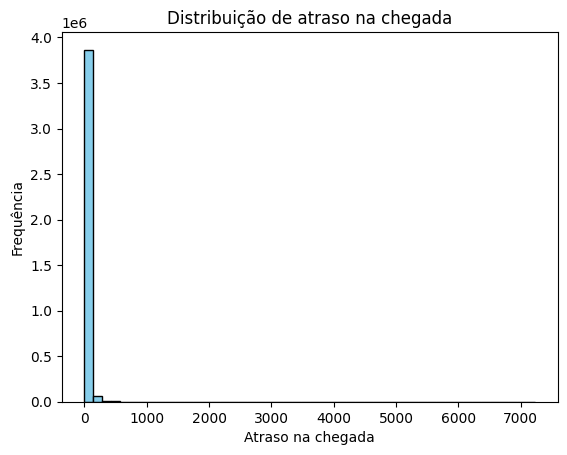

In [16]:
arr_delay_values = dataframe.select("ArrDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.hist(arr_delay_values, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Atraso na chegada")
plt.ylabel("Frequência")
plt.title("Distribuição de atraso na chegada")
plt.show()

In [45]:
# Group delays by DayOfWeek
delay_by_day = dataframe.groupBy("DayOfWeek").agg(F.avg("ArrDelayMinutes").alias("avg_delay")).orderBy("DayOfWeek")
print("\n Atraso medio por dia da semana:")
delay_by_day.show()


 Atraso medio por dia da semana:


+---------+------------------+
|DayOfWeek|         avg_delay|
+---------+------------------+
|        1| 15.74601072509473|
|        2|11.869317071120992|
|        3|12.726657243841833|
|        4|16.852069657735345|
|        5|18.470271691679443|
|        6| 17.33519092649646|
|        7| 17.26704135159071|
+---------+------------------+



In [17]:
allowed_types = ['int', 'double']

# Filtrando colunas com tipos permitidos
selected_columns = [col_name for col_name, col_type in dataframe.dtypes if any(data_type in col_type for data_type in allowed_types)]

# Selecionando apenas as colunas permitidas
df_filtered = dataframe.select(*selected_columns)

# Mostrando o esquema do DataFrame resultante
df_filtered.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)



# Pré processamento

In [18]:
target = "OriginAirportID"
feature_columns = df_filtered.columns
feature_columns.remove(target)
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = vector_assembler.transform(df_filtered)

In [19]:
# Dividindo o conjunto de dados entre treino e teste
train_data, test_data = df_vector.randomSplit(
    [0.8, 0.2], # 80% treino e 20% teste
    seed=42 # Semente de aleatoriedade
)

# Model

In [20]:
rf_classifier = RandomForestClassifier(labelCol=target, featuresCol="features", numTrees=10)
pipeline = Pipeline(stages=[rf_classifier])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="OriginAirportID", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


24/04/27 11:56:25 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed: Classifier inferred 16870 from label values in column RandomForestClassifier_f88be10b29b2__labelCol, but this exceeded the max numClasses (100) allowed to be inferred from values.  To avoid this error for labels with > 100 classes, specify numClasses explicitly in the metadata; this can be done by applying StringIndexer to the label column.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.Classifier.getNumClasses(Classifier.scala:157)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:143)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.sc

IllegalArgumentException: requirement failed: Classifier inferred 16870 from label values in column RandomForestClassifier_f88be10b29b2__labelCol, but this exceeded the max numClasses (100) allowed to be inferred from values.  To avoid this error for labels with > 100 classes, specify numClasses explicitly in the metadata; this can be done by applying StringIndexer to the label column.